DATA CREATION

In [1]:
import pandas as pd
import numpy as np

np.random.seed(23)

n = 500

df = pd.DataFrame({
    'User_ID': np.arange(1, n + 1),
    'Login_Count': np.random.poisson(15, n),
    'Avg_Session_Duration_Min': np.round(np.random.normal(12, 5, n), 1),
    'Feature_Usage_Score': np.round(np.random.uniform(0, 1, n), 2),
    'Tickets_Raised': np.random.poisson(2, n),
    'Days_Since_Last_Login': np.random.randint(1, 90, n),
    'Churned': np.random.choice([0, 1], size=n, p=[0.8, 0.2])
})

df.to_csv("user_churn_data.csv", index=False)


## Tasks:
1. Behavioral Profiling:  
    Segment users into behavioral buckets (e.g., high usage but churned, low usage but loyal).
    - Use clustering or conditional filtering.
    - Visualize patterns with bar or scatter plots.

2. Key Drivers of Churn:
    - Which variables most strongly differentiate churned vs. non-churned users?
    - What’s the profile of a likely-to-churn user?

3. Suggest Fixes and Experiments:
    - 2 changes (product, UX, or communication) that might reduce churn.
    - 1 creative campaign idea to re-engage users who haven't logged in for 30+ days.

In [2]:
df.head()

,User_ID,Login_Count,Avg_Session_Duration_Min,Feature_Usage_Score,Tickets_Raised,Days_Since_Last_Login,Churned
0,1,18,3.8,0.07,2,74,0
1,2,11,14.9,0.83,2,46,0
2,3,11,6.3,0.59,1,12,0
3,4,16,7.5,0.79,1,53,0
4,5,20,15.4,0.80,3,15,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   User_ID                   500 non-null    int64  
 1   Login_Count               500 non-null    int32  
 2   Avg_Session_Duration_Min  500 non-null    float64
 3   Feature_Usage_Score       500 non-null    float64
 4   Tickets_Raised            500 non-null    int32  
 5   Days_Since_Last_Login     500 non-null    int32  
 6   Churned                   500 non-null    int64  
dtypes: float64(2), int32(3), int64(2)
memory usage: 21.6 KB


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

In [5]:
df['Churned'].value_counts() / df.shape[0] * 100

Churned
0    77.8
1    22.2
Name: count, dtype: float64

In [6]:
# df[df['Churned']==1]['Days_Since_Last_Login']

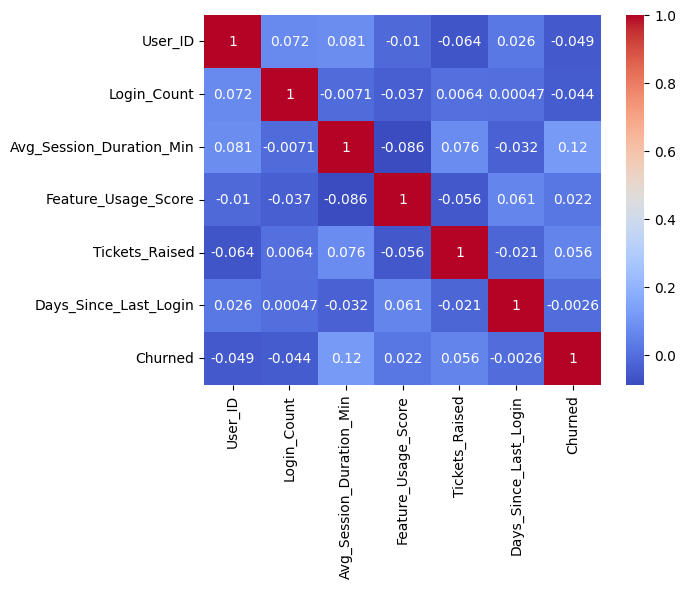

In [7]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

Rule-Based Segmentation (Using Conditional Filtering)

In [8]:
# Usage flag
df['Usage'] = np.where(df['Login_Count'] > df['Login_Count'].median(), 'High', 'Low')

# Lets combine this with churn 
df['User_behavior'] = df['Usage'] + ' Usage - ' + np.where(df['Churned']==1, 'Churned', 'Loyal')

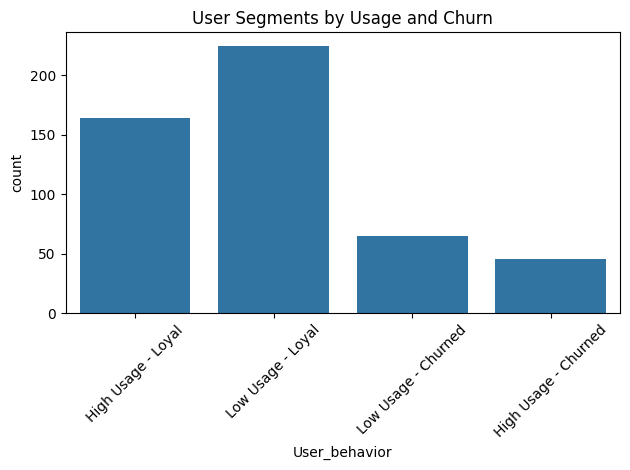

In [9]:
sns.countplot(data=df, x='User_behavior')
plt.title("User Segments by Usage and Churn")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Mean comparison
df.groupby('Churned').mean(numeric_only=True)

,User_ID,Login_Count,Avg_Session_Duration_Min,Feature_Usage_Score,Tickets_Raised,Days_Since_Last_Login
Churned,,,,,,
0,254.305913,14.982005,11.369409,0.509563,1.863753,43.092545
1,237.162162,14.540541,12.866667,0.525315,2.036036,42.927928


In [11]:
from scipy.stats import ttest_ind

for col in ['Login_Count', 'Avg_Session_Duration_Min', 'Feature_Usage_Score', 'Tickets_Raised', 'Days_Since_Last_Login']:
    churned = df[df['Churned'] == 1][col]
    loyal = df[df['Churned'] == 0][col]
    t_stat, p_value = ttest_ind(churned, loyal)
    print(f"{col}: p-value = {p_value:.5f}")


Login_Count: p-value = 0.33106
Avg_Session_Duration_Min: p-value = 0.00817
Feature_Usage_Score: p-value = 0.62151
Tickets_Raised: p-value = 0.21096
Days_Since_Last_Login: p-value = 0.95407


Features with p < 0.05 are significantly different between churned and non-churned users.

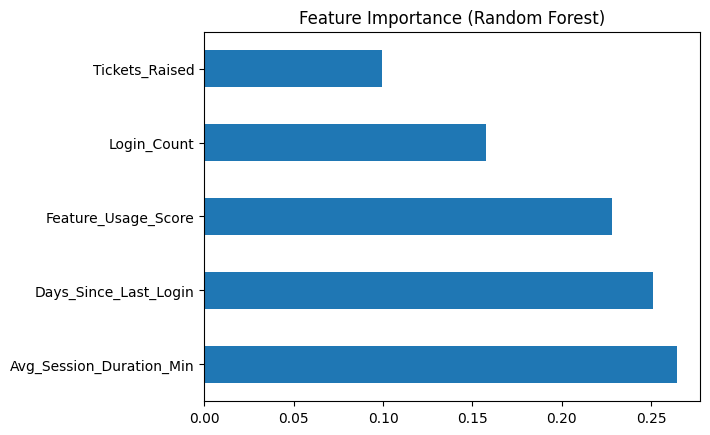

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = df[['Login_Count', 'Avg_Session_Duration_Min', 'Feature_Usage_Score', 'Tickets_Raised', 'Days_Since_Last_Login']]
y = df['Churned']

model = RandomForestClassifier(random_state=42)
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='barh', title="Feature Importance (Random Forest)")
plt.show()

In [22]:
loyal_users = df[df['Churned'] == 0]
loyal_usage_summary = loyal_users.groupby('Usage').mean(numeric_only=True)
print(loyal_usage_summary)

          User_ID  Login_Count  Avg_Session_Duration_Min  Feature_Usage_Score  \
Usage                                                                           
High   267.121951    19.042683                 11.221341             0.499329   
Low    244.964444    12.022222                 11.477333             0.517022   

       Tickets_Raised  Days_Since_Last_Login  Churned  
Usage                                                  
High         1.871951              44.731707      0.0  
Low          1.857778              41.897778      0.0  
